<a href="https://www.kaggle.com/code/wonduk/pytorch-lstm-daily-climate-forecasting?scriptVersionId=159641621" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="font-family:Times New Roman;"> <center><b>Daily Climate Forecasting Using Pytorch, LSTM </b></center> </h1>
<p><center style="color:black; font-family : Times New Roman">| WONDUK | </center></p>


![](https://storage.googleapis.com/kaggle-datasets-images/312121/636393/a5097396fc07cf882d3e0d631b100a36/dataset-cover.jpg?t=2019-08-23-15-00-53)

***

<h1 style = 'font-family: Times New Roman'> <b>|</b><i> 1. Content</i></h1>

<br>

> <h4 style = 'font-family: Times New Roman'>
The Dataset is fully dedicated for the developers who want to train the model on Weather Forecasting for Indian climate.<br><br> This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India. <br><br>The 4 parameters here are
meantemp, humidity, wind_speed, meanpressure.
    
  
<h1 style = 'font-family: Times New Roman'> <b>|</b><i> 2. About Dataset</i></h1>

<br> 
    
5 columns in the dataset, below is <u>description of features</u>:

*  (1) <b>meantemp</b>: Mean temperature averaged out from multiple 3 hour intervals in a day. 
    
*  (2) <b>humidity</b>: Humidity value for the day (units are grams of water vapor per cubic meter volume of air).
    
    
*  (3) <b>wind_speed</b>: Wind speed measured in kmph.
    
    
*  (4) <b>meanpressure</b>: Pressure reading of weather (measure in atm)
    
    
<h1 style = 'font-family: Times New Roman'> <b>|</b><i> 3. Goal of the Notebook</i></h1>
    
> <h4 style = 'font-family: Times New Roman'>
Goal is to train and test model using LSTM, Pytorch. <br><br>
    The Target Column used here is <b>meantemp</b>
</h4>

 

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
    <b><h1 style = 'font-family: Times New Roman'> |<i> 4. Table of Contents</i></h1></b>
    
   * [1. Import Necessary Libraries](#1)
   * [2. Data Visualization](#2)
   * [3. Feature Engineering](#3)
   * [4. Modeling: Preprocess](#4)
   * [5. Modeling: LSTM Model](#5)
   * [6. Final: Model Evaluation](#6)

***

<a id="1"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #42c2f5'>1.</b> Import Necessary Libraries </b></h1>

In [1]:
# Data
import numpy as np
import pandas  as pd

# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torch.utils.data as data
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Evaluation 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
train_df = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
test_df = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv')

<a id="2"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #42aaf5'>2.</b> Data Visualization </b></h1>

<b> Define self-defined Visualization Functions to plot distribution of each features </b>

In [3]:
# Box Plot / Line Plot
class plotly_graph:
    def __init__(self, data, date):
        self.data = data
        self.date = date
        self.name_lst = ['Mean Temp', 'Humidity', 'Wind Speed', 'Mean Pressure']
        self.box_title = 'Multiple Box Plots'
        self.line_title = 'Multiple Line Plots'
    
#################### function to make subplots ######################
    def make_subplot(self, graphs):
        fig = make_subplots(rows=2, cols=2, subplot_titles=(self.name_lst))
        for i in range(4): fig.add_trace(graphs[i], row=i // 2 + 1, col=i % 2 + 1)
        return fig
    
#################### 1. Box Plot ######################
    def box_plot(self):
        graph_lsts = []
        for i, element in enumerate(self.data.transpose()):
            graph_lst = go.Box(y = element,
                               name = self.box_title,
                               boxpoints = 'outliers',
                               line = dict(width=1))    
            graph_lsts.append(graph_lst)
        fig = self.make_subplot(graph_lsts)
        fig.update_layout(title=self.box_title,
                          xaxis_title='Columns',
                          yaxis_title='Values',
                          template = 'simple_white')
        fig.show()

#################### 2. Line Plot ######################
    def line_plot(self):
        line_lsts = []
        for i, element in enumerate(self.data.transpose()):
            line = go.Scatter(x = self.date,
                               y = element,
                               mode = 'lines',
                               name = self.line_title)
            line_lsts.append(line)
        fig = self.make_subplot(line_lsts)
        fig.update_layout(title=self.line_title,
                          xaxis_title='Columns',
                          yaxis_title='Values',
                          template = 'simple_white')
        fig.show()

In [4]:
data_ = train_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].values

graph = plotly_graph(data_, train_df['date'])

<b> Box Plots: </b>

In [5]:
graph.box_plot()

<b> Line Plots </b>

In [6]:
graph.line_plot()

We can see that there's some outliers in train set, columns 'Wind Spped' and 'Mean Pressure'.

<a id="3"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #429ef5'>3.</b> Feature Engineering </b></h1>

* 1. Get New column: <u>'humidity pressure ratio'</u> <br><br>
* 2. Get Date Columns: <u>'year'</u>, <u>'month'</u>, <u>'day'</u>

In [7]:
# Create new column 'humidity_pressure_ratio' using humidity and meanpressure

def humidity_pressure_ratio(df):
    df['humidity_pressure_ratio'] = df['humidity'] / df['meanpressure']
    return df

# split date column to create 'year', 'month' and 'day'
def get_date_columns(date):
    year, month, day = date.split('-')
    return (year, month, day)

# apply func
train_df = humidity_pressure_ratio(train_df)
test_df = humidity_pressure_ratio(test_df)

# apply func
tr_date_cols = train_df['date'].apply(get_date_columns)
te_date_cols = test_df['date'].apply(get_date_columns)

train_df[['year', 'month', 'day']] = pd.DataFrame(tr_date_cols.tolist(), index=train_df.index)
test_df[['year', 'month', 'day']] = pd.DataFrame(te_date_cols.tolist(), index=test_df.index)

In [8]:
print('Train set \n\n')
train_df.head()

Train set 




,date,meantemp,humidity,wind_speed,meanpressure,humidity_pressure_ratio,year,month,day
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,0.083197,2013,01,01
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,0.090391,2013,01,02
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,0.085406,2013,01,03
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,0.070129,2013,01,04
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,0.085424,2013,01,05


<a id="4"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'>4.</b> Modeling: Preprocess </b></h1>

In [9]:
# feature selection 

tr_timeseries = train_df[['month', 'day', 'humidity', 'wind_speed', 'meanpressure', 'humidity_pressure_ratio', 'meantemp']].values.astype('float32')
te_timeseries = test_df[['month', 'day',  'humidity', 'wind_speed', 'meanpressure', 'humidity_pressure_ratio', 'meantemp']].values.astype('float32')

new = pd.concat([train_df, test_df], axis=0).reset_index().drop('index', axis=1)
new_timeseries = new[['month', 'day',  'humidity', 'wind_speed', 'meanpressure',  'humidity_pressure_ratio', 'meantemp']].values.astype('float32')

# scaling using MinMax
scaler = MinMaxScaler()
tr_timeseries = scaler.fit_transform(tr_timeseries)
te_timeseries = scaler.transform(te_timeseries)

In [10]:
# lookback: 7

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[:,:6][i:i+lookback]
        target = dataset[:, 6][i:i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 5

train, test = tr_timeseries, te_timeseries
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

# modify shape of train and test
X_train, X_test = X_train, X_test
y_train, y_test = y_train, y_test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)



In [11]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train),
                         batch_size = 32, shuffle = True)

<a id="5"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #427bf5'>5.</b> Modeling</b></h1>

<b> First, define Modeling Class 'LSTMModel'</b>

In [12]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = 6, 
                            num_layers = 2,
                            hidden_size = 128,  
                            batch_first = True, 
                            bidirectional= True)
        
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(128*2, 256) 
        self.linear2 = nn.Linear(256, 32)
        self.linear3 = nn.Linear(32, 8) 
        self.output_linear = nn.Linear(8, 1)
        
        
    def forward(self, x):  
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.output_linear(x)
        return x

<b> Call module, and define optimizer and loss function </b>

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# call model
model = LSTMModel()

# optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

# loss func: MSE
loss_fn = nn.MSELoss()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

<b> Define Early Stopping Function </b>

In [14]:
class CustomEarlyStopping:
    def __init__(self, patience=30, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None
    
    def __call__(self, val_loss, model, X):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')
    
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            self.counter = 0
            
early_stopping = CustomEarlyStopping(patience=15, verbose=True)

<b> Train with using pre-defined functions above </b>

In [15]:
best_score = None
best_weights = None
best_train_preds = None
best_test_preds = None

n_epochs = 250

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred.squeeze(), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    
    with torch.no_grad():
        y_pred = model(X_train) 
        train_rmse = np.sqrt(loss_fn(y_pred, y_train.unsqueeze(2)))
        train_preds = y_pred.clone().detach().cpu().numpy()
        
        y_pred = model(X_test) 
        test_rmse = np.sqrt(loss_fn(y_pred, y_test.unsqueeze(2)))
        test_preds = y_pred.clone().detach().cpu().numpy()
        
        # Update the learning rate scheduler and early stopping
        scheduler.step(test_rmse)
        
        if best_score is None or test_rmse < best_score:
            best_score = test_rmse
            best_weights = model.state_dict()
            best_train_preds = train_preds
            best_test_preds = test_preds
        
        early_stopping(test_rmse, model, X_test)
        
        # Check if early stopping criterion is met
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    if epoch % 5 == 0:
        print('*'*10, 'Epoch: ', epoch, '\ train RMSE: ', train_rmse, '\ test RMSE', test_rmse)

********** Epoch:  0 \ train RMSE:  tensor(0.2175) \ test RMSE tensor(0.2018)
EarlyStopping counter: 1 out of 15, score: -0.15032142400741577
EarlyStopping counter: 2 out of 15, score: -0.15032142400741577
********** Epoch:  5 \ train RMSE:  tensor(0.0774) \ test RMSE tensor(0.1107)
EarlyStopping counter: 1 out of 15, score: -0.10181295871734619
EarlyStopping counter: 1 out of 15, score: -0.08535172045230865
********** Epoch:  10 \ train RMSE:  tensor(0.0649) \ test RMSE tensor(0.0901)
EarlyStopping counter: 2 out of 15, score: -0.08535172045230865
EarlyStopping counter: 3 out of 15, score: -0.08535172045230865
EarlyStopping counter: 4 out of 15, score: -0.08535172045230865
EarlyStopping counter: 1 out of 15, score: -0.08392360061407089
********** Epoch:  15 \ train RMSE:  tensor(0.0631) \ test RMSE tensor(0.0898)
EarlyStopping counter: 2 out of 15, score: -0.08392360061407089
EarlyStopping counter: 3 out of 15, score: -0.08392360061407089
EarlyStopping counter: 4 out of 15, score: -0.

<a id="6"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #4251f5'>6.</b> Final: Model Evaluation</b></h1>

<b>Get Predicted Values of Train set and Test set</b>

In [16]:
if best_weights is not None:
    model.load_state_dict(best_weights)
    
    # Use the best weights to generate predictions
    with torch.no_grad():
        y_pred_train = model(X_train).clone().detach().cpu().numpy()
        y_pred_test = model(X_test).clone().detach().cpu().numpy()

In [17]:
with torch.no_grad():
    train_plot = np.ones_like(new_timeseries) * np.nan
    train_plot[lookback: len(train)] = y_pred_train[:,-1,:]
    
    test_plot = np.ones_like(new_timeseries) * np.nan
    test_plot[len(train)+lookback:len(new_timeseries)] = y_pred_test[:,-1,:]

In [18]:
train_predictions = scaler.inverse_transform(train_plot)
test_predictions = scaler.inverse_transform(test_plot)

In [19]:
import plotly.express as px
import plotly.graph_objects as go

<b> Plot Predicted Values and Original Values</b>

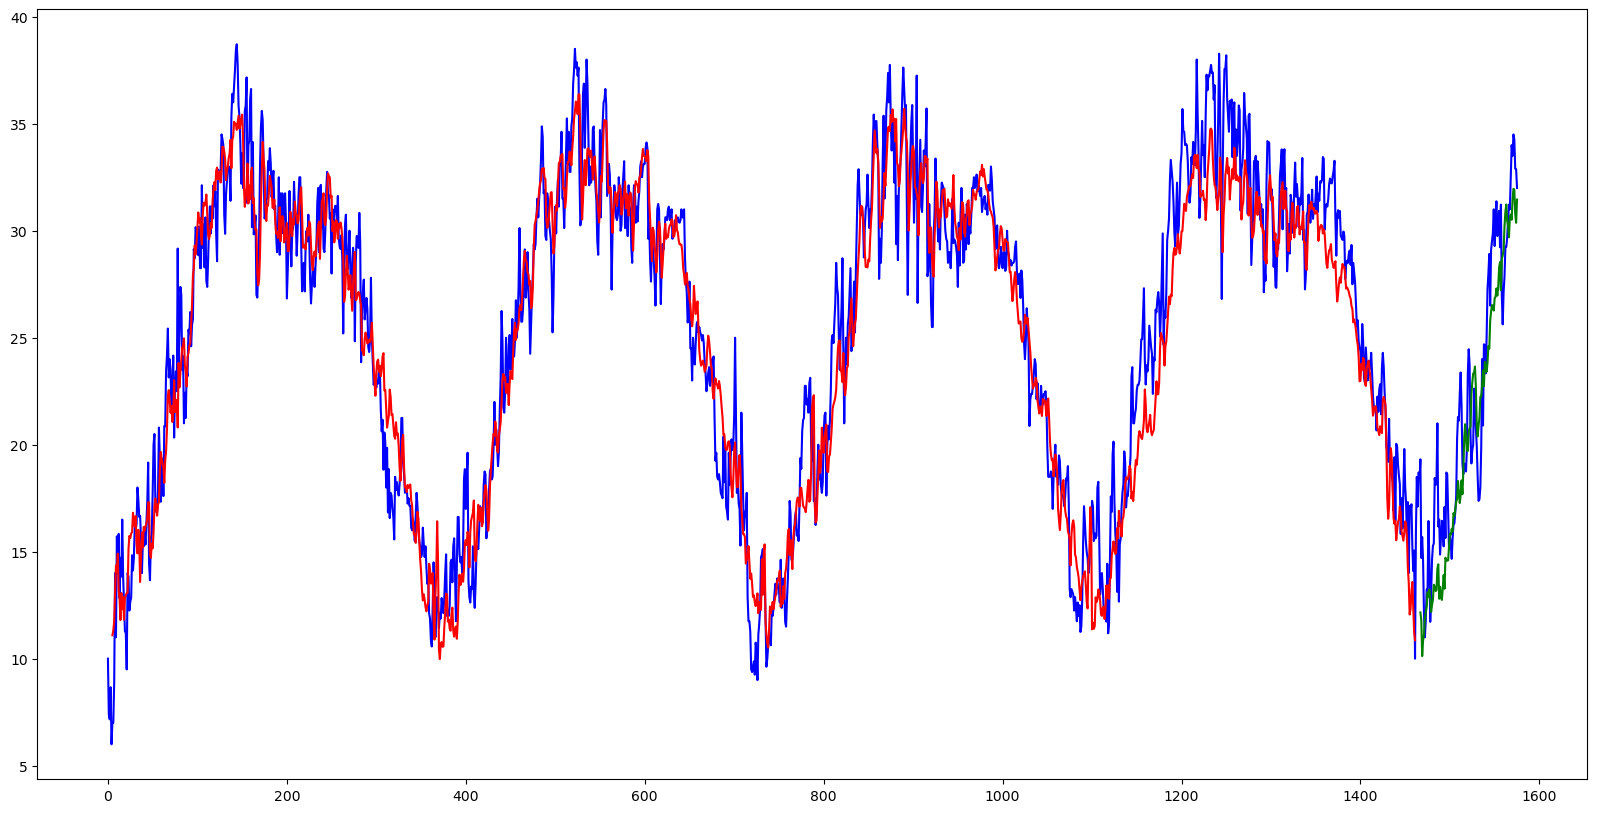

In [20]:
# plot
plt.figure(figsize=(20,10))
plt.plot(new_timeseries[:,6], c = 'b')
plt.plot(train_predictions[:,6], c='r')
plt.plot(test_predictions[:,6], c='g')


# plt.xlim([500,1000])
# plt.ylim([100000, 7000ㅋ00])
plt.show()

In [21]:
eval_df = pd.concat([test_df['meantemp'].reset_index(),
                  pd.Series(test_predictions[:,6][len(train):].reshape(-1).tolist())],axis=1).drop('index',axis=1)

eval_df.columns = ['real_meantemp', 'pred_meantemp']

In [22]:
fig = go.Figure(data = [
    go.Line(x = eval_df.index, y = eval_df['real_meantemp'], name = "Actual"),
    go.Line(x = eval_df.index, y = eval_df['pred_meantemp'], name="Predict"),
])

fig.update_layout(
    font = dict(size=17,family="Franklin Gothic"),
    template = 'simple_white',
    title = 'Real & Predicted Temp')

fig.show()

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




<b> And Our RMSE Score: </b>

In [23]:
np.sqrt(mean_squared_error(eval_df.iloc[5:]['real_meantemp'], eval_df.iloc[5:]['pred_meantemp']))

2.8247974198281676

## <div style="text-align: center; background-color:#ECF0F1 ; font-family:Times New Roman; color: black; padding: 40px; line-height: 1;border-radius:40px"> 🙇Thanks For Watching ! -wonduk<br><br>Please upvote if you like this notebook !</div>